### Using RGDR
This notebook outlines the current status of the RGDR implementation.

First we will load in some example data, and resample them using the `AdventCalendar`

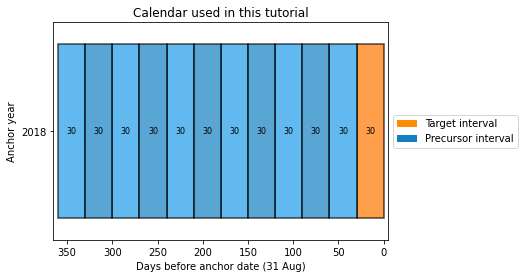

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import s2spy.time
import s2spy.rgdr
from s2spy import RGDR

file_path = '../tests/test_rgdr/test_data'
field = xr.open_dataset(f'{file_path}/sst_daily_1979-2018_5deg_Pacific_175_240E_25_50N.nc')
target = xr.open_dataset(f'{file_path}/tf5_nc5_dendo_80d77.nc')

cal = s2spy.time.AdventCalendar((8, 31), freq = "30d")
cal = cal.map_to_data(field)
field_resampled = s2spy.time.resample(cal, field)
target_resampled = s2spy.time.resample(cal, target)

cal.visualize(add_freq=True, n_years=1)
_ = plt.title("Calendar used in this tutorial")

### The target timeseries comes from already pre-clustered land surface temperature data.

In [2]:
target_timeseries = target_resampled.sel(cluster=3).ts.isel(i_interval=0)
precursor_field = field_resampled.sst.isel(i_interval=slice(1,5)) # Multiple lags: 1 through 4

rgdr = RGDR(eps_km=600, alpha=0.05, min_area_km2=3000**2)

Using `.plot_correlation` we can see the correlation and p-value map of the target timeseries and precursor field:

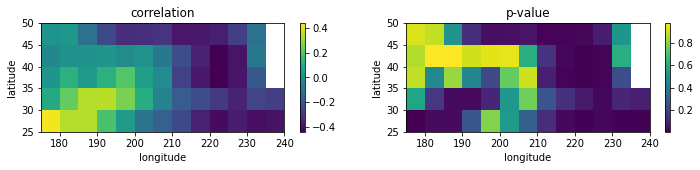

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))
_ = rgdr.plot_correlation(precursor_field, target_timeseries, lag=1, ax1=ax1, ax2=ax2)

We can compare two RGDR initializations to preview what the effect on the generated clusters will be.

Note that the second figure has an extra cluster, due to the minimum area argument having a smaller value.

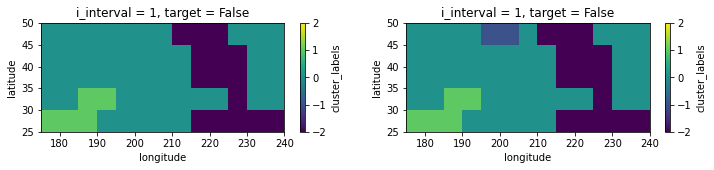

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 2))

_ = rgdr.plot_clusters(precursor_field, target_timeseries, lag=1, ax=ax1)

_ = RGDR(eps_km=600, min_area_km2=None).plot_clusters(precursor_field, target_timeseries,
                                                      lag=1, ax=ax2)

With `.fit` the RGDR clustering can be fit to a precursor field.
`.transform` can then be used to return the data reduced to clusters:

In [5]:
rgdr.fit(precursor_field, target_timeseries)
clustered_data = rgdr.transform(precursor_field)
xr.set_options(display_expand_data=False) # Hide the full data repr
clustered_data

<xarray.DataArray 'sst' (anchor_year: 39, cluster_labels: 6)>
290.8 298.9 287.8 296.6 286.0 284.9 ... 291.4 298.2 288.4 296.6 286.9 285.1
Coordinates:
  * anchor_year     (anchor_year) int32 1980 1981 1982 1983 ... 2016 2017 2018
  * cluster_labels  (cluster_labels) <U20 'lag:1_cluster:-2' ... 'lag:4_clust...
    latitude        (cluster_labels) float64 36.05 29.44 37.33 29.58 38.14 39.78
    longitude       (cluster_labels) float64 223.9 185.4 221.8 190.2 217.8 219.3
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...

Now we can plot the data for each cluster:

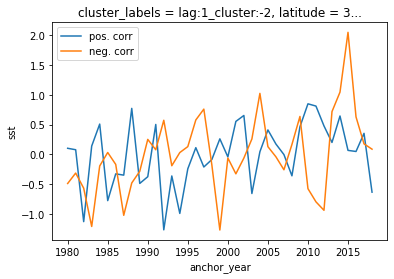

In [6]:
import matplotlib.pyplot as plt

clustered_data -= clustered_data.mean(dim='anchor_year')
clustered_data.sel(cluster_labels="lag:1_cluster:1").plot.line(x='anchor_year', label='pos. corr')
clustered_data.sel(cluster_labels="lag:1_cluster:-2").plot.line(x='anchor_year', label='neg. corr')
plt.legend()

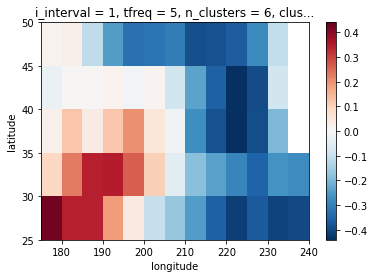

In [7]:
# visualize correlation map after RGDR().fit(precursor_field, target_timeseries)
rgdr.corr_map[0].plot()

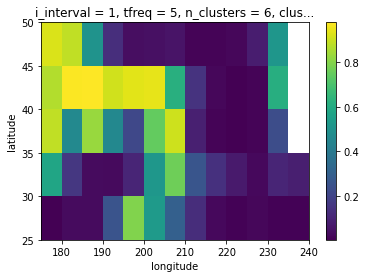

In [8]:
# visualize p-values map
rgdr.pval_map[0].plot()

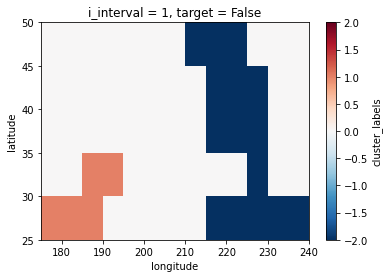

In [9]:
# visualize clusters
from s2spy.rgdr.utils import cluster_labels_to_ints
cluster_map = cluster_labels_to_ints(rgdr.cluster_map.copy())
cluster_map.cluster_labels[0].plot()